### Restoration of the degraded audio

In [ ]:
import diffwave # github installation: !git clone https://github.com/lmnt-com/diffwave.git
import torch
import numpy as np
from diffwave.dataset import *
from diffwave.params import params, AttrDict
from diffwave.preprocess import *
from diffwave.model import *
from scipy.fftpack import fft
import torchaudio

# source: https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from diffwave.inference import predict as diffwave_predict

model_dir = './../models/pretrained/diffwave-ljspeech-22kHz-1000578.pt'

def white_noise(n, sigma, mu=0):
    """
    parameters: 
    rho - spectral noise density unit/SQRT(Hz)
    sr  - sample rate
    n   - no of points
    mu  - mean value, optional

    returns:
    n points of noise signal with spectral noise density of rho
    """
    noise = np.random.normal(mu, sigma, n)
    return noise

def calc_snr(audio):
    fft_signal = fft(audio)
    power_signal = np.sum(np.abs(fft_signal)**2)
    power_noise = np.sum(np.abs(fft_signal[fft_signal < 0.001])**2)
    snr = 10*np.log10(power_signal/power_noise)
    return snr

freqs = [20,50,100,200]
sigmas =  [5, 10, 15, 20] #[64, 128, 256, 512] # [1,2,5,10,20]

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 553.13it/s]


Freq: 20, sigma: 5 


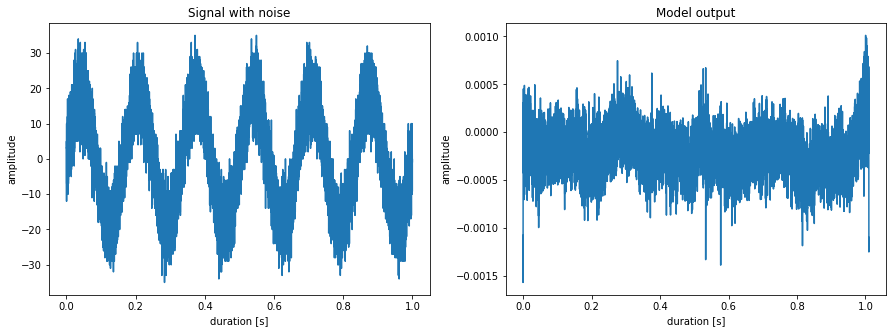

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 538.13it/s]


Freq: 20, sigma: 10 


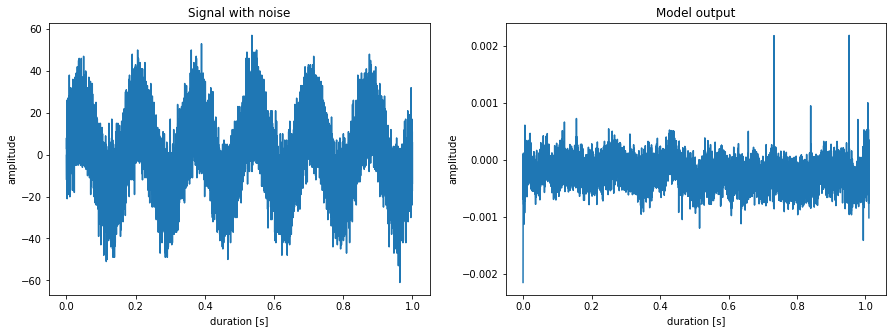

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 593.13it/s]


Freq: 20, sigma: 15 


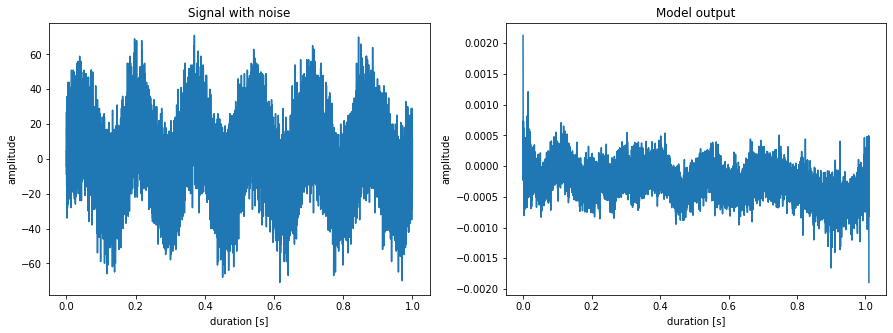

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 546.16it/s]


Freq: 20, sigma: 20 


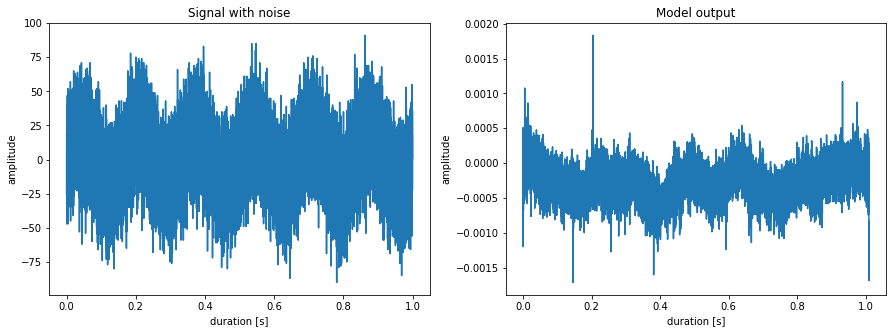

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 503.66it/s]


Freq: 50, sigma: 5 


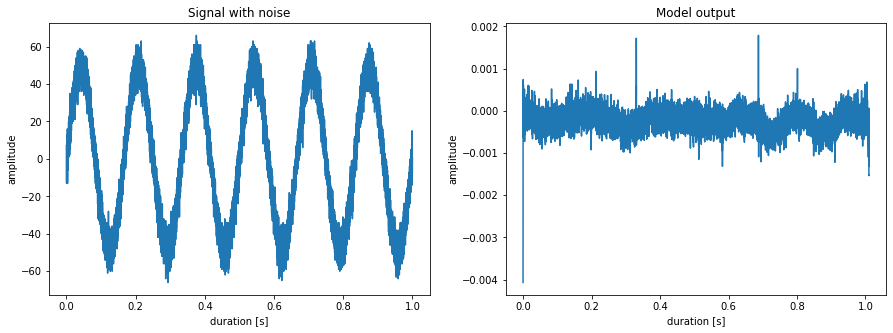

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 484.77it/s]


Freq: 50, sigma: 10 


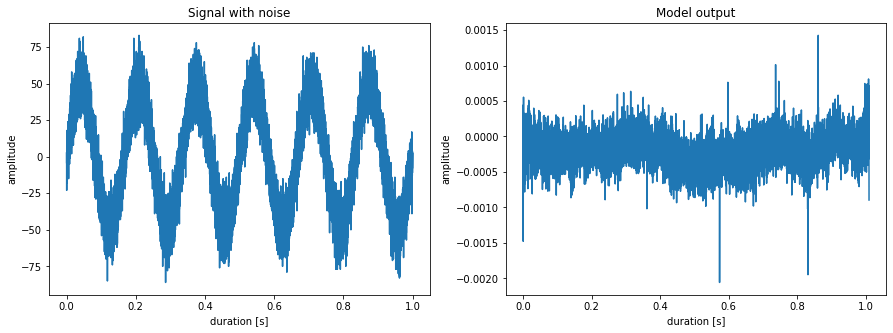

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 469.73it/s]


Freq: 50, sigma: 15 


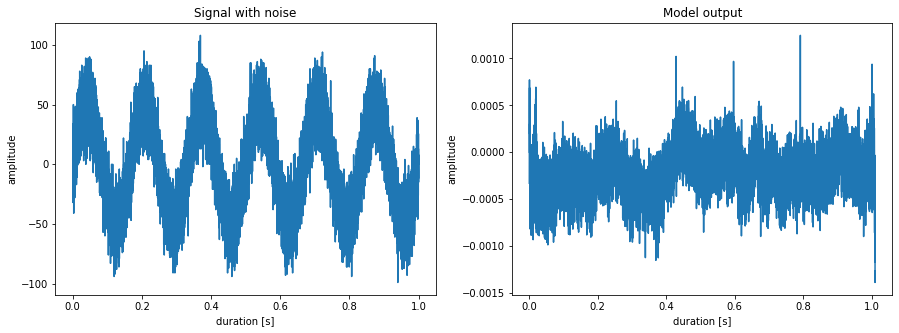

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 495.77it/s]


Freq: 50, sigma: 20 


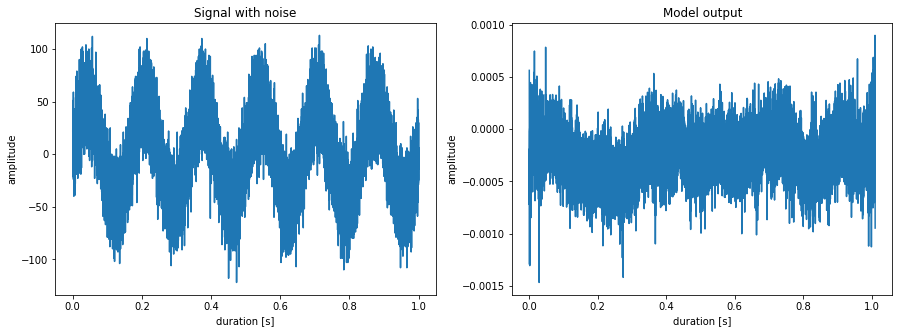

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 515.07it/s]


Freq: 100, sigma: 5 


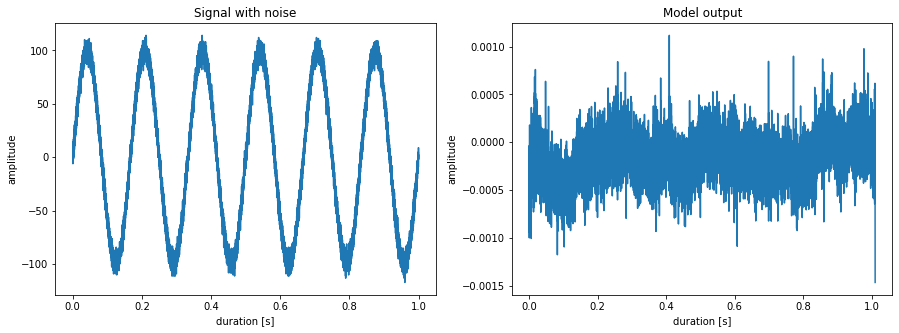

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 562.77it/s]


Freq: 100, sigma: 10 


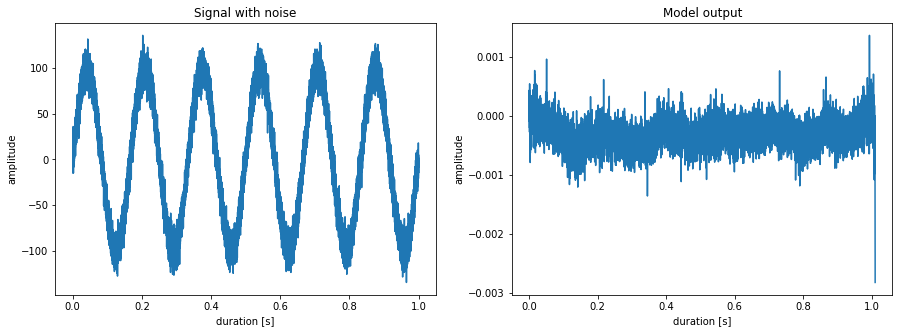

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 496.05it/s]


Freq: 100, sigma: 15 


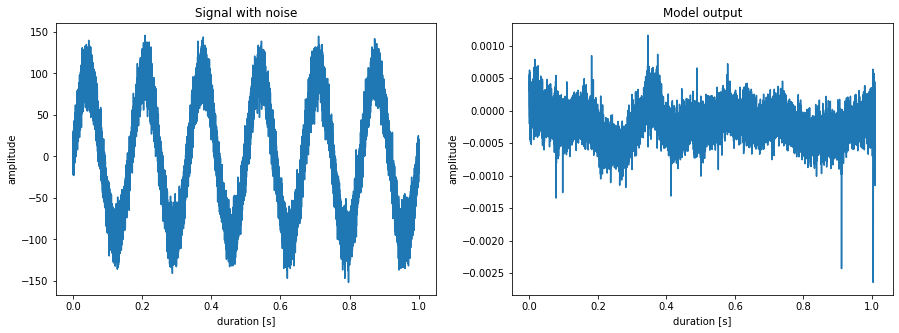

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 480.00it/s]


Freq: 100, sigma: 20 


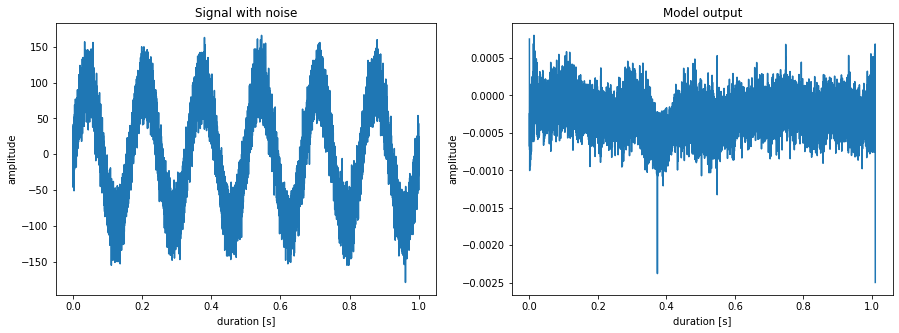

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 503.79it/s]


Freq: 200, sigma: 5 


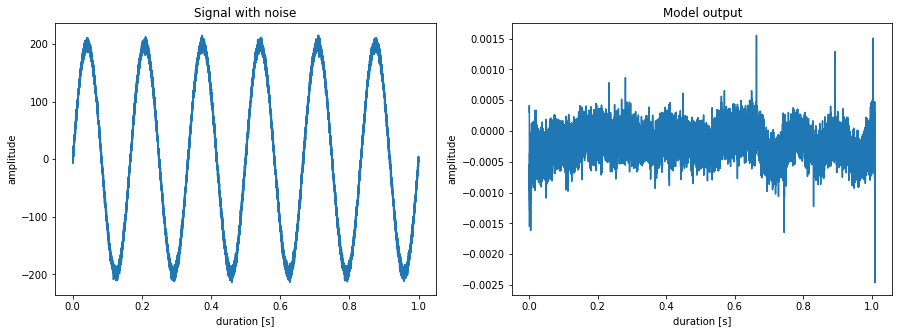

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 527.58it/s]


Freq: 200, sigma: 10 


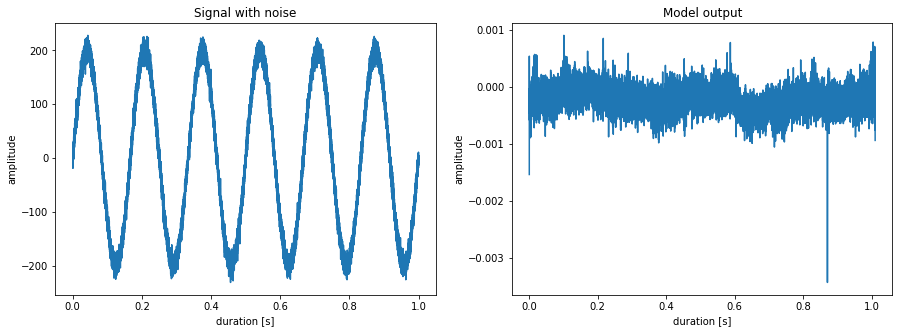

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 509.45it/s]


Freq: 200, sigma: 15 


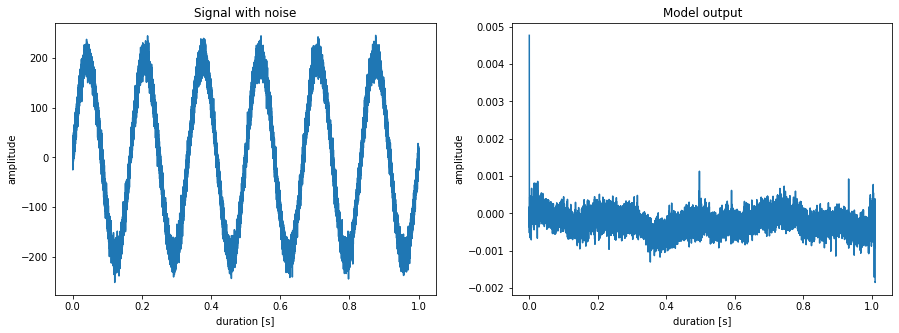

Preprocessing: 100%|██████████| 121/121 [00:00<00:00, 525.38it/s]


Freq: 200, sigma: 20 


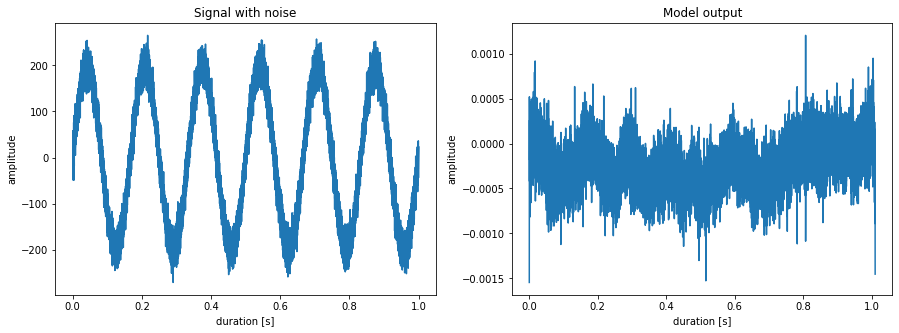

In [ ]:
results = []
params = []
for f in freqs:
  for sig in sigmas:
    # generating waves
    rho = 1 # spectral noise density unit/SQRT(Hz)
    sr = 22050 # sampling rate
    n = 22050 # 1s
    period = n/sr
    time = np.linspace(0, period, n)
    signal_pure = np.int16(f*np.sin(2*np.pi*6*time))
    sigma = int(rho * sig) 
    noise = white_noise(rho, sr, n, sigma)
    signal_with_noise = np.int16(signal_pure + noise)
    # saving both audios (variance of the noise and length of the audio as 'parameters' - different options tried out)
    wavfile.write(f'signal_pure_{period}s.wav', sr, signal_pure)
    wavfile.write(f'signal_with_noise_{period}s_{sigma}var_{f}freq.wav', sr, signal_with_noise)
    # spectrogram
    diffwave.preprocess.main(AttrDict({'dir': '.'}))
    # prediction
    spectrogram = np.load(f"signal_with_noise_{period}s_{sigma}var_{f}freq.wav.spec.npy")
    x = torch.from_numpy(spectrogram)
    audio, sample_rate = diffwave_predict(x, model_dir, fast_sampling=True)
    # saving the output audio
    cpu = torch.device("cpu")
    torchaudio.save(f'./spectrograms/signal_with_noise_{period}s_{sigma}var_{f}freq_output.wav', audio.to(cpu), sample_rate)

    snr_pure = calc_snr(signal_pure)
    snr_noise = calc_snr(signal_with_noise)
    snr_out = calc_snr(audio.to(cpu).numpy())
    params.append([f,sig])
    results.append([snr_pure, snr_noise, snr_out])

    print(f'Freq: {f}, sigma: {sigma} ')
    fig, ax = plt.subplots(1,2,figsize=(15,5))

    ax[0].plot(signal_with_noise) # original audio with noise
    ax[0].set_title('Signal with noise')
    ax[0].set_xticks([0, int(0.2*22050), int(0.4*22050), int(0.6*22050), int(0.8*22050), 22050])
    ax[0].set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax[0].set_xlabel('duration [s]')
    ax[0].set_ylabel('amplitude')

    ax[1].plot(audio.to(cpu).numpy()[0]) # output audio
    ax[1].set_title('Model output')
    ax[1].set_xticks([0, int(0.2*22050), int(0.4*22050), int(0.6*22050), int(0.8*22050), 22050])
    ax[1].set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax[1].set_xlabel('duration [s]')
    ax[1].set_ylabel('amplitude')
    plt.show()


In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
params_df = pd.DataFrame(params)
total = pd.concat([params_df, results_df], axis=1)
total.columns=['Freq', 'Sigma', 'SNR pure', 'SNR noise', 'SNR output']
total = total.round(2)

In [ ]:
total.to_csv('./results/results_snr.csv')

In [ ]:
total

,Freq,Sigma,SNR pure,SNR noise,SNR output
0,20,5,33.23,12.16,1.39
1,20,10,33.23,7.58,1.03
2,20,15,33.23,1.41,1.40
3,20,20,33.23,1.86,1.24
4,50,5,41.29,19.92,1.04
5,50,10,41.29,14.16,1.34
6,50,15,41.29,11.09,1.35
7,50,20,41.29,9.11,1.37
8,100,5,47.29,25.98,2.01
9,100,10,47.29,20.02,0.86
